In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from src.embedding import Embedding
from src.forward_kinematics import ForwardKinematic
from src.dynamical_system import DynamicalSystem

# DS

In [2]:
# DS parameters
config_dim = 2
K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)
# config_attractor = np.array([0.9, -0.9])
config_attractor = np.array([1., 0.15])

# Embedding parameters
# x = torch.tensor([[-0.5], [0.8], [0.]])
x = np.array([[-0.6], [1.5], [0.]])[np.newaxis, :]

fk = ForwardKinematic(urdf_file='2_joints_arm.urdf')

joint_limits = [{'lower': -np.pi, 'upper': np.pi}, {'lower': -np.pi, 'upper': np.pi}]
e = Embedding(dimension=2, x=x.repeat(1, 0), fk=fk, limits=joint_limits)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

In [3]:
# start = np.array([-0.55, 0.85])
# start = np.array([-0.19, 0.828])
start = np.array([-0.5, -1.2])
initial_speed = np.array([0.1, 0.1])
q = start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,5000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')

average execution frequency : 2294.4350 Hz


# FK + Embedding

In [4]:
q1 = np.linspace(joint_limits[0]['lower'], joint_limits[0]['upper'], 100)
q2 = np.linspace(joint_limits[1]['lower'], joint_limits[1]['upper'], 100)
gridX, gridY = np.meshgrid(q1, q2)
grid = np.column_stack((gridX.ravel(), gridY.ravel()))
print(grid.shape)

(10000, 2)


In [5]:
a = np.zeros((grid.shape[0], 3))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q).sum()
    a[i] = np.array([q[0], q[1], p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 28293.584841711676


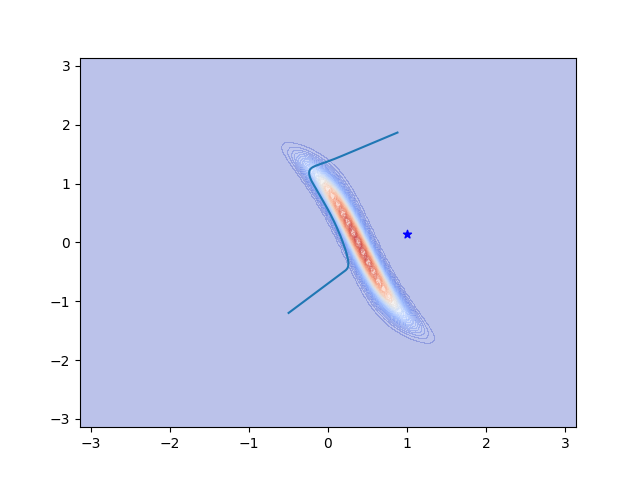

In [6]:
x1 = np.unique(a[:, 0])
x2 = np.unique(a[:, 1])
z = a[:, 2].reshape((x1.shape[0], x2.shape[0]))

ps= np.stack(positions)
%matplotlib widget
plt.figure()
plt.contourf(x1, x2, z, cmap=cm.coolwarm, alpha=0.35, levels=50)
plt.scatter(config_attractor[0], config_attractor[1], label='attractor', marker='*', c='b')
plt.plot(ps[:, 0], ps[:, 1])
plt.xlim([x1.min(), x1.max()])
plt.ylim([x2.min(), x2.max()])
plt.show()

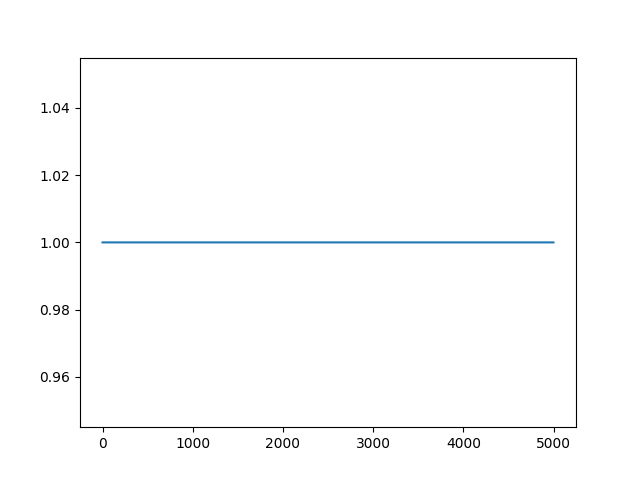

In [7]:
sigma =np.stack(ds.weight_logger)
plt.figure()
plt.plot(range(len(ds.weight_logger)), sigma)
plt.show()

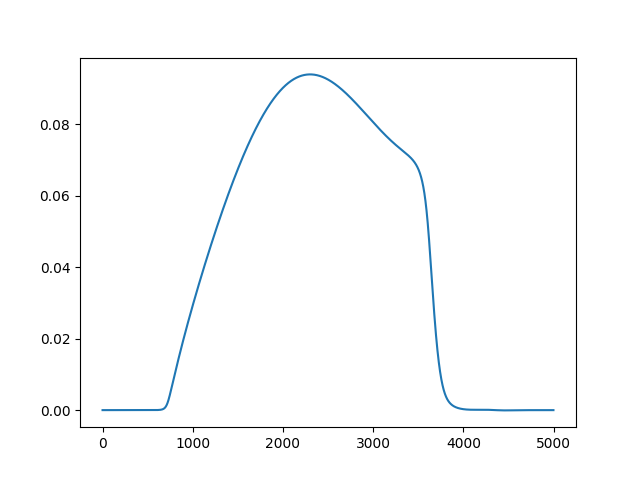

In [8]:
sigma =np.stack(ds.gr_logger)
plt.figure()
plt.plot(range(sigma.shape[0]), sigma)
plt.show()

In [9]:
np.min(sigma[:1000])

-1.1362643714109548e-10

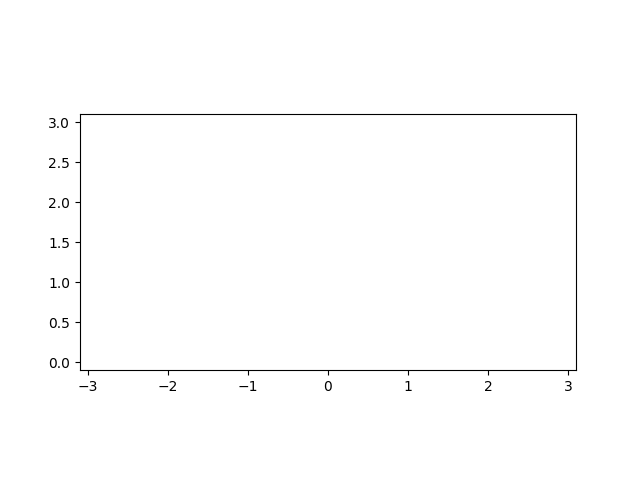

In [10]:
import pinocchio as pin
from matplotlib import animation

def animate_robot(i, configurations, fk: ForwardKinematic, ax):
    ax.clear()
    ax.set_xlim([-3.1, 3.1])
    ax.set_ylim([-0.1, 3.1])
    # ax.plot(config_attractor[0], config_attractor[1], 'y*', markersize=20, markeredgecolor='black', markeredgewidth=1)
    # for obs in [obstacle]:
    ax.scatter(x[:, 0], x[:, 1], c='r', s=12)
    q = configurations[i]
    pin.forwardKinematics(fk.model, fk.data, q)
    pin.updateFramePlacements(fk.model, fk.data)
    _ = fk(q=q, dq=np.zeros_like(q), derivation_order=0)
    mus = fk.mus
    ax.scatter(mus[:, 0], mus[:, 1], c='m', s=25)
    # Plot the target point with a border
    ee = fk.data.oMf[fk.model.getFrameId('ee')].translation
    link2 = fk.data.oMf[fk.model.getFrameId('link2')].translation
    base = fk.data.oMf[fk.model.getFrameId('link1')].translation
    # Plot the base of the robotic arm with a border
    alpha = 1.0 if i == 0 else 0.5  # Adjust opacity based on configuration index
    ax.plot(base[0], base[1], 'bo', markersize=20, alpha=alpha, markeredgecolor='black', markeredgewidth=3, zorder=10)
    ax.plot([base[0], link2[0]], [base[1], link2[1]], 'k-', linewidth=8, alpha=alpha)  # Link
    ax.plot(link2[0], link2[1], 'ko', markersize=10, markeredgecolor='black', markeredgewidth=1, zorder=10)  # Joint

    # Plot the end effector of the robotic arm with a border
    ax.plot([link2[0], ee[0]], [link2[1], ee[1]], 'k-', linewidth=8, alpha=alpha)  # Link
    ax.plot(ee[0], ee[1], 'go', markersize=10, markeredgecolor='black', markeredgewidth=3, zorder=10)


fig, ax = plt.subplots()
# ax.scatter(x[0], x[1], c='r', s=12)
ax.set_aspect('equal', 'box')
ax.set_xlim([-3.1, 3.1])
ax.set_ylim([-0.1, 3.1])
dt = 0.001
step = int(np.round(0.016/dt))
ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, ps.shape[0], step, dtype=np.intc),fargs=(ps, fk, ax), interval=step*dt*1000, repeat=False)
# ani.save('vid.mp4')